In [20]:
import pickle
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from collections import namedtuple
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.evaluation import *

### Baseline classification performance on EEG Dataset

Get with 5 fold cross-validation and performance on the test set
- Load the data of each user for all tests 
- Get performance per user - attention, interest, effort
- Get performance per user 

### 1) Load the data

In [4]:

# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# prepare cross validation
kfold = KFold(n_splits = 3, shuffle = True, random_state =  1)
# enumerate splits
for train, test in kfold.split(data):
	print('train: %s, test: %s' % (data[train], data[test]))

train: [0.1 0.4 0.5 0.6], test: [0.2 0.3]
train: [0.1 0.2 0.3 0.4 0.6], test: [0.5]
train: [0.2 0.3 0.4 0.5 0.6], test: [0.1]
train: [0.1 0.2 0.3 0.5 0.6], test: [0.4]
train: [0.1 0.2 0.3 0.4 0.5], test: [0.6]


In [85]:
def run_clf(labels, dataset, dataset_type, user, results, evaluate):
        
        for label in labels:
            
            
            if dataset_type == "per user":
                X = dataset[user].iloc[:, :-8]
                y = dataset[user][label]
            else:
                X = dataset.iloc[:, :-8]
                y = dataset[label]
            
            num_classes = len(set(y))
            objective = 'multiclass'
            if num_classes == 2:
                objective = 'binary'

            #Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

            #create the model 
            clf =  LGBMClassifier(objective=objective,num_leaves=31, learning_rate=0.1, random_state=5).fit(X_train, y_train)
            
            if evaluate == '5_fold_CV':
                y_pred = cross_val_predict(clf, X_train,y_train, cv=5)
                r = get_results(y_train, y_pred)
            else:
                y_pred = clf.predict(X_test)
                r = get_results(y_test, y_pred)
            

            # get results
            Results = namedtuple("Results","user label num_classes accuracy bal_acc precision recall f1_score_macro f1_score_micro")
            results.append(Results(user, label, num_classes, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                                  r['F1 Score Macro'], r['F1 Score Micro']))
            # plot confusion matrix
            plot_confusion_matrix(clf, X_test, y_test, normalize='true')
            plt.savefig("results/baseline/confusion matrices/{0}_performance/User_{1}_{2}.png".format(evaluate,user,label))

In [19]:
def average(lst): 
    return sum(lst) / len(lst) 

In [1]:
def kfold_predict(X,Y):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    total_predictions = []
    total_true = []
    for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        #Train/test split
        X_train, X_test = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_test = np.concatenate(y[train_index]), np.conatenate(y[test_index])
        total_true.appenad(y_test)

        #create the model 
        clf =  LGBMClassifier(objective=objective,num_leaves=31, learning_rate=0.1, random_state=5).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        total_predictions.append(y_test)
        r = get_results(y_test, y_pred) # get dictionary of all results

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[metric].append(r[key])

    for key in results: # average out the results 
        results[key] = average(results[key])

    return results, total_predictions, total_true

In [17]:
def get_results_per_user():
    saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
    with open(saved_file, 'rb') as handle:
        all_users = pickle.load(handle)
    users = all_tests.keys()
    user = 1
    labels = ['attention','interest','effort']
    for label in labels:
        user_dict = all_users[1] # dictionary storing all the tests of a user
        X = np.array(user_dict["inputs"]) # array of all the inputs for each test
        y = np.array(user_dict[label]) # array of given labels for each test
        
        # get results
        r, y_pred, y_true = kfold_predict(X,Y)
        cm = confusion_matrix(y_true, y_pred)
        Results = namedtuple("Results","user label accuracy bal_acc precision recall f1_score_macro f1_score_micro")
        results.append(Results(user, label, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                              r['F1 Score Macro'], r['F1 Score Micro']))

        
        # plot confusion matrix
        plot_confusion_matrix(clf, X_test, y_test, normalize='true')
        plt.savefig("results/baseline/confusion matrices/{0}_performance/User_{1}_{2}.png".format(evaluate,user,label))
    

In [18]:
get_results_per_user()

TRAIN: [ 0  1  2  4  5  8  9 10 11 12 13 14] TEST: [3 6 7]
TRAIN: [ 0  1  3  5  6  7  8  9 11 12 13 14] TEST: [ 2  4 10]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 14] TEST: [ 0  1 13]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13] TEST: [ 8  9 14]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14] TEST: [ 5 11 12]
TRAIN: [ 0  1  2  4  5  8  9 10 11 12 13 14] TEST: [3 6 7]
TRAIN: [ 0  1  3  5  6  7  8  9 11 12 13 14] TEST: [ 2  4 10]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 14] TEST: [ 0  1 13]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13] TEST: [ 8  9 14]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14] TEST: [ 5 11 12]
TRAIN: [ 0  1  2  4  5  8  9 10 11 12 13 14] TEST: [3 6 7]
TRAIN: [ 0  1  3  5  6  7  8  9 11 12 13 14] TEST: [ 2  4 10]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 14] TEST: [ 0  1 13]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13] TEST: [ 8  9 14]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14] TEST: [ 5 11 12]


In [3]:
saved_file = "data/all_tests_EEG.pickle"
with open(saved_file, 'rb') as handle:
    all_tests = pickle.load(handle)

In [55]:
set(all_tests[12]['interest'])

{1.0, 2.0, 3.0, 4.0}

In [75]:
def combine_all_users(all_tests):
    all_users = []
    for key in all_tests:
        all_users.append(all_tests[key])
        print(len(all_tests[key]))
    all_users = pd.concat(all_users)
    return all_users

In [76]:
all_users_combined = combine_all_users(all_tests)
len(all_users_combined)

85991
155966
145361
171763
174558
222319
251940
35673
82768
11120
107552
177374
48850
142794
138960
236532
109652
261336


2560509

### Performance per user

Just added test results for User 1
Just added test results for User 2
Just added test results for User 3
Just added test results for User 6
Just added test results for User 7
Just added test results for User 8


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Just added test results for User 9


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 10


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 11


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 12


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 17


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 18


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 19


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 20


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 22


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 23


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 24


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.fig

Just added test results for User 25


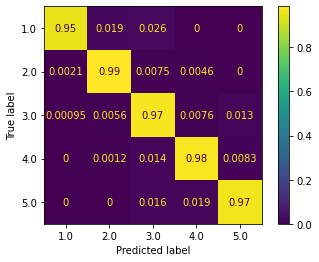

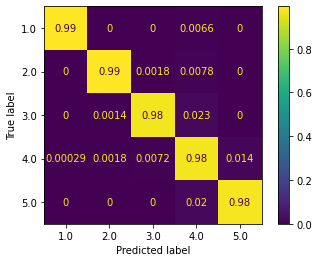

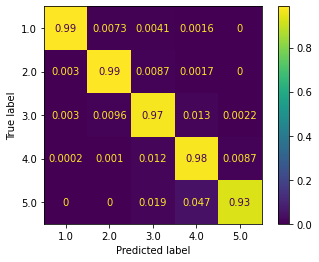

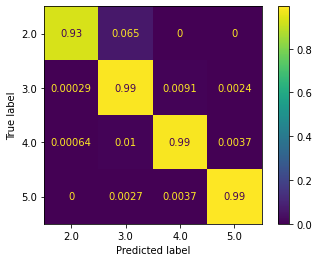

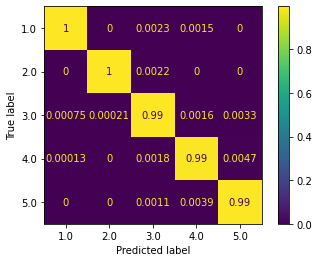

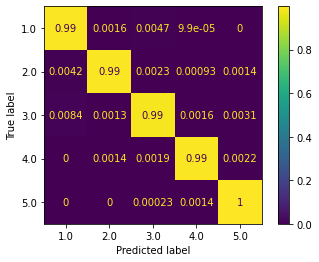

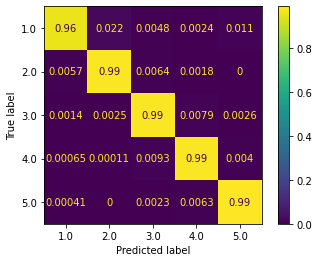

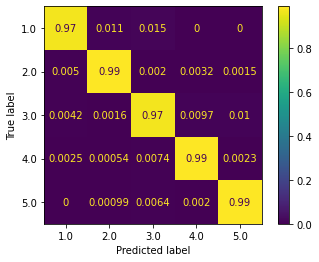

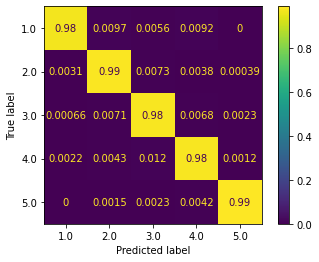

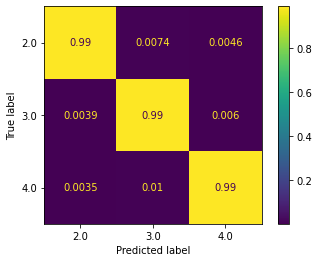

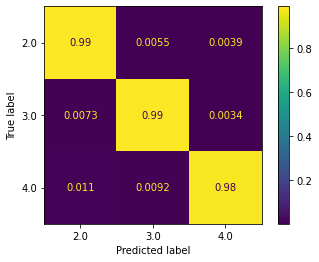

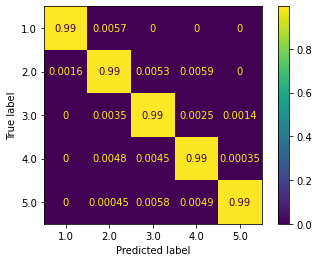

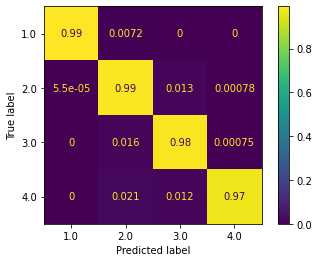

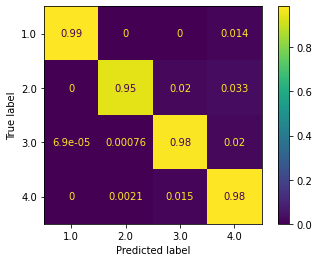

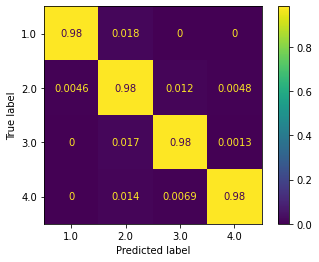

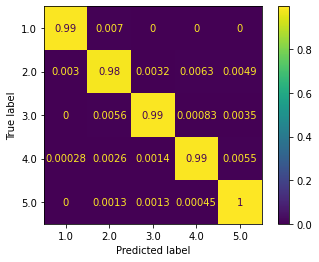

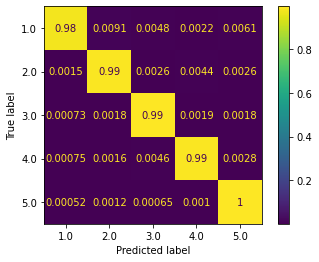

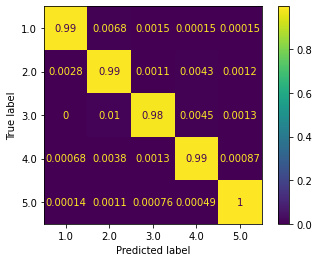

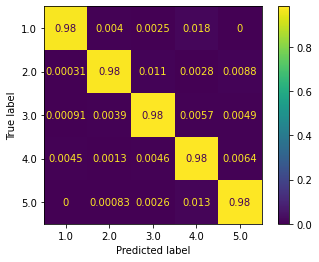

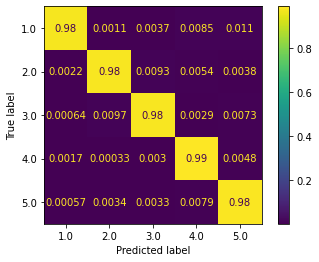

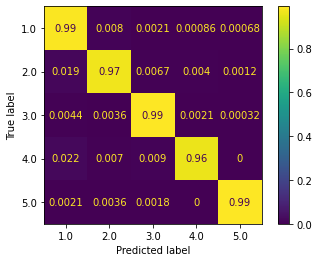

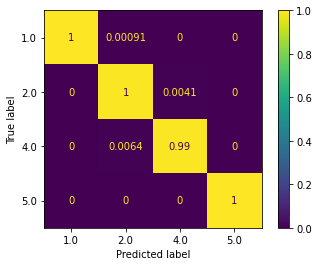

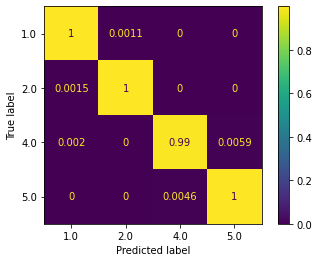

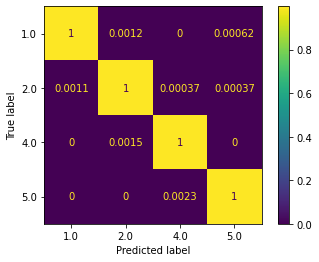

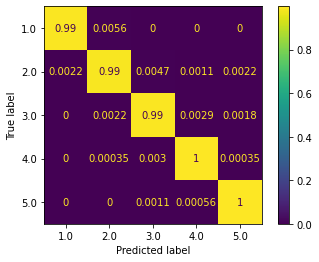

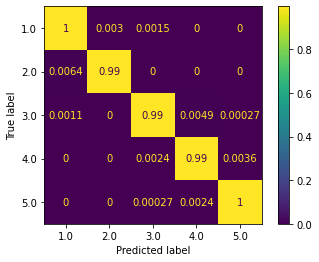

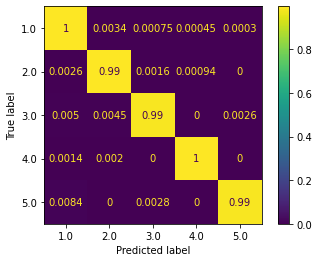

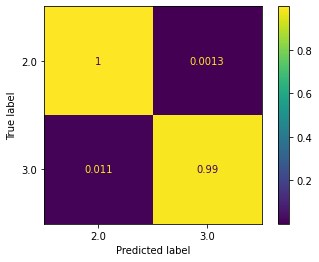

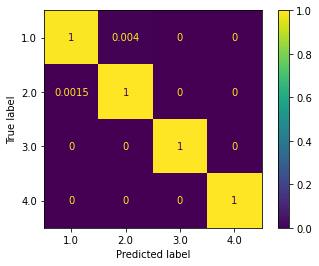

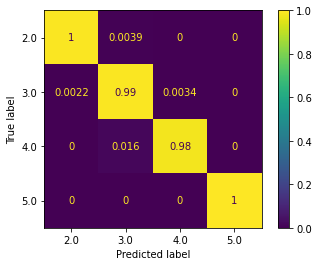

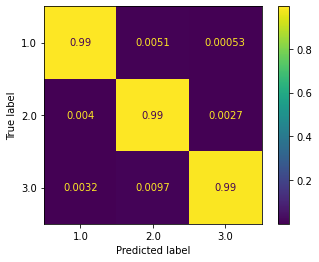

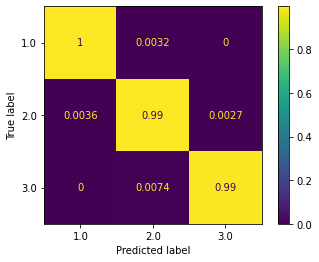

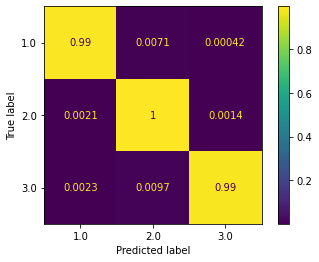

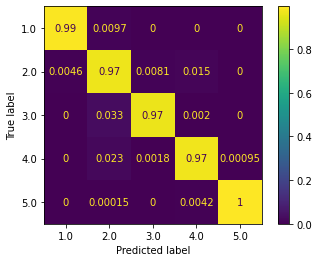

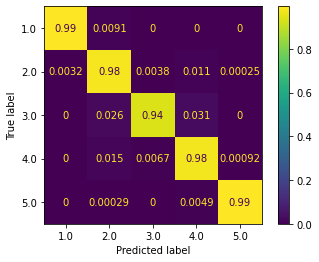

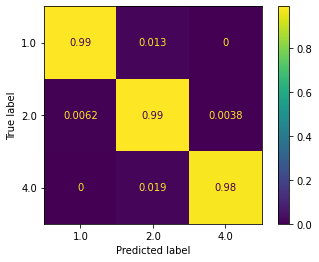

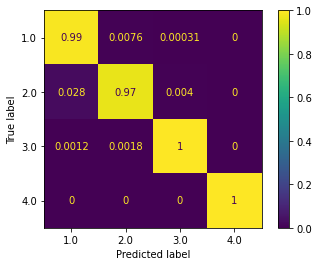

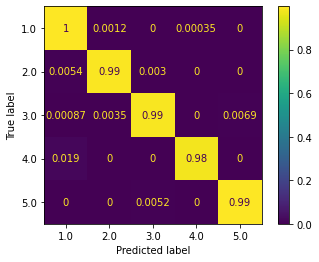

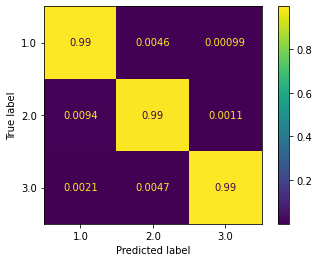

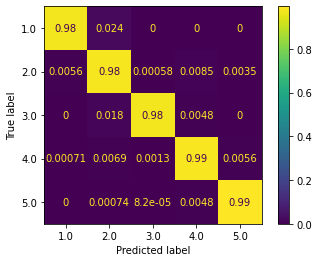

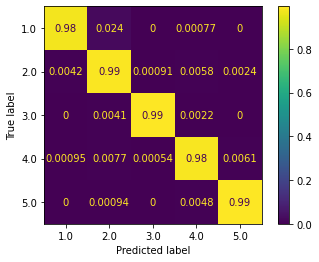

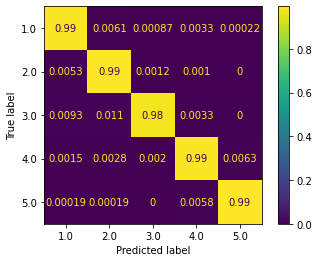

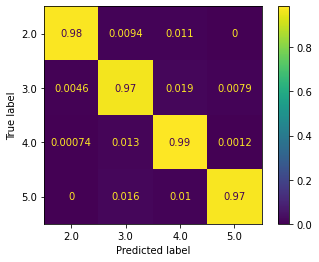

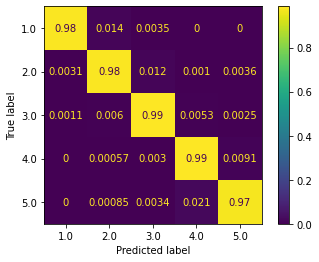

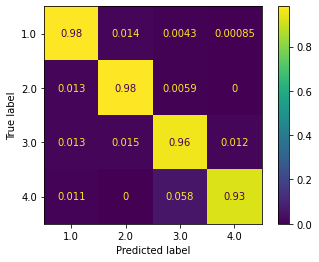

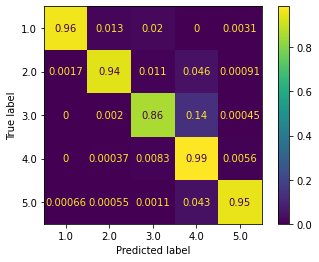

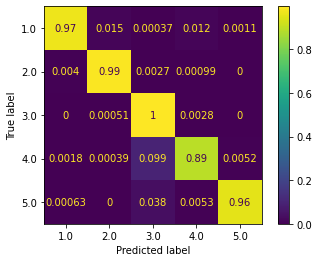

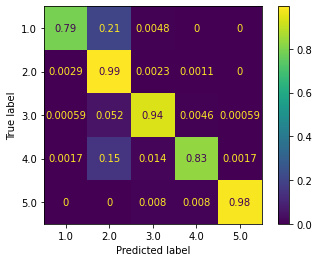

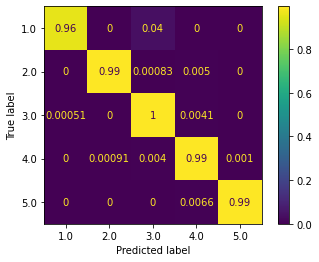

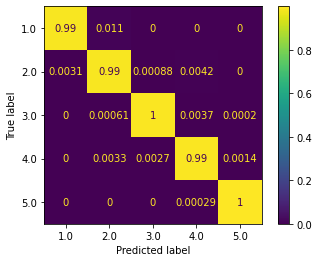

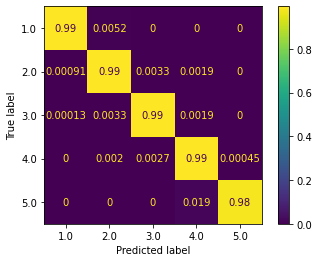

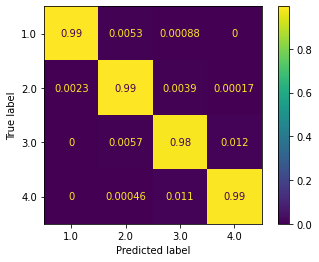

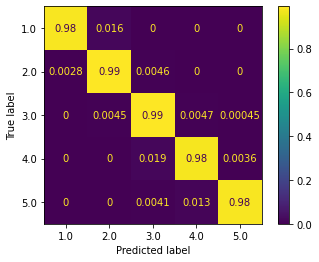

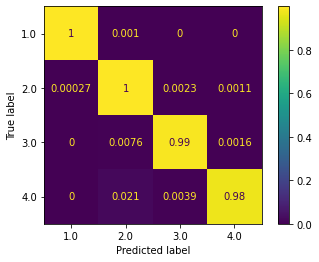

In [69]:
#select the inputs and labels
# remove user 12
user_list = all_tests.keys()
results = []
labels = ["attention", "interest", "effort"]
# for user in user_list:
#     run_clf(labels, all_tests, 'per user', user, results, '5_fold_CV')
#     print("Just added test results for User {0}".format(user))
# results  = pd.DataFrame(results).to_csv("results/baseline/tabulated/LGBM_5_fold_CV_performance_per_user.csv".format(dataset_type), index=False)


### All users 

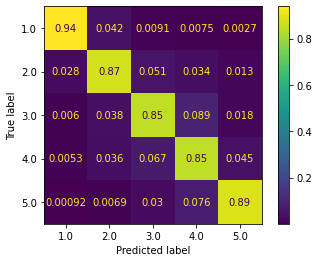

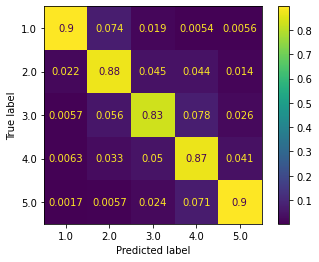

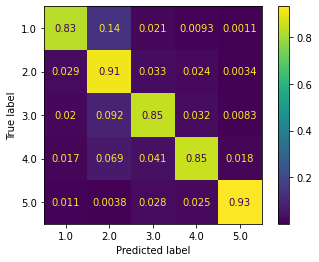

In [86]:
results = []
run_clf(labels, all_users_combined, 'all_users', 'all', results, '5_fold_CV')
results  = pd.DataFrame(results).to_csv("results/baseline/tabulated/LGBM_5_fold_CV_performance_all_users.csv", index=False)

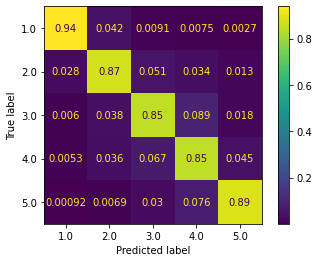

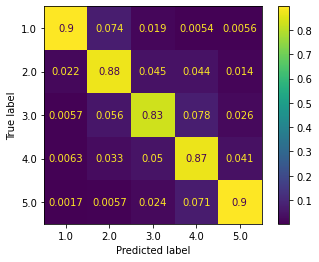

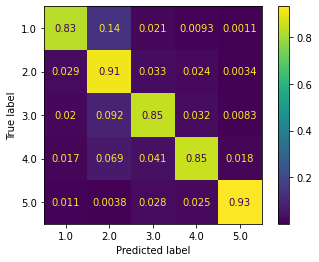

In [87]:
results = []
run_clf(labels, all_users_combined, 'all_users', 'all', results, 'test')
results  = pd.DataFrame(results).to_csv("results/baseline/tabulated/LGBM_test_performance_all_users.csv", index=False)